In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
eng_df = pd.read_csv(r"C:\Users\josia\Desktop\Relax Inc - Take Home Challenge\1481069814_relax_challenge\relax_challenge\takehome_user_engagement.csv")

In [14]:
user_df = pd.read_csv(r"C:\Users\josia\Desktop\Relax Inc - Take Home Challenge\1481069814_relax_challenge\relax_challenge\takehome_users.csv", encoding='ISO-8859-1')

In [15]:
eng_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [16]:
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


# Problem

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven­day  period ,  identify  which  factors  predict  future  user
adoption .

Advice: We  suggest  spending  1­2  hours  on  this,  but  you're  welcome  to  spend  more  or  less.
Please  send  us  a  brief  writeup  of  your  findings  (the  more  concise,  the  better  ­­  no  more
than  one  page),  along  with  any  summary  tables,  graphs,  code,  or  queries  that  can  help
us  understand  your  approach.  Please  note  any  factors  you  considered  or  investigation
you  did,  even  if  they  did  not  pan  out.  Feel  free  to  identify  any  further  research  or  data
you  think  would  be  valuable.

In [17]:
eng_df.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [21]:
eng_df['time_stamp'] = pd.to_datetime(eng_df['time_stamp'])
eng_df.dtypes

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object

In [26]:
eng_df.head()

,time_stamp,user_id,visited,login_day
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [27]:
eng_df.sort_values(['user_id', 'login_day'])

,time_stamp,user_id,visited,login_day
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25
...,...,...,...,...
207912,2013-09-06 06:14:15,11996,1,2013-09-06
207913,2013-01-15 18:28:37,11997,1,2013-01-15
207914,2014-04-27 12:45:16,11998,1,2014-04-27
207915,2012-06-02 11:55:59,11999,1,2012-06-02


In [28]:
def check_adopted_user(group):
    group['adopted_user'] = (group['login_day'].rolling(window=3, on='login_day')
                            .apply(lambda x: (x.max() - x.min()).days <= 7, raw=False)
                            .fillna(0)
                            .astype(int))
    return group

In [32]:
def check_adopted_user(group):
    # Apply a rolling window over the sorted 'login_day' within each group
    group = group.sort_values('login_day')  # Ensure sorting by date for each user
    group['adopted_user'] = (group['login_day'].diff(periods=2)
                             .le(pd.Timedelta(days=7))
                             .fillna(0)
                             .astype(int))
    return group

# Apply function and reset index to remove 'user_id' as index level
eng_df_test = eng_df.groupby('user_id').apply(check_adopted_user).reset_index(drop=True)

# Mark user as adopted if any of their rolling windows shows 'adopted_user' = 1
eng_df_test['adopted_user'] = eng_df_test.groupby('user_id')['adopted_user'].transform('max')

# Drop duplicates to get one row per user
final_df = eng_df_test[['user_id', 'adopted_user']].drop_duplicates()

print(final_df)


        user_id  adopted_user
0             1             0
1             2             1
15            3             0
16            4             0
17            5             0
...         ...           ...
207912    11996             0
207913    11997             0
207914    11998             0
207915    11999             0
207916    12000             0

[8823 rows x 2 columns]


In [41]:
print('total adopted users:', (final_df['adopted_user'] == 1).sum())
print('total non-adopted users:', (final_df['adopted_user'] == 0).sum())


total adopted users: 1656
total non-adopted users: 7167


In [54]:
user_df.rename(columns = {'object_id': 'user_id'}, inplace=True)

In [55]:
user_df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [56]:
merged_df = pd.merge(user_df, final_df, on='user_id', how='left')
merged_df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


In [65]:
merged_df.isnull().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted_user                  3177
dtype: int64

In [67]:
merged_df = merged_df.dropna(subset=['adopted_user'])

In [68]:
merged_df.isnull().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
adopted_user                     0
dtype: int64

In [69]:
merged_df.dtypes

user_id                         int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
adopted_user                  float64
dtype: object

In [70]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

merged_df['creation_source_enc'] = label_encoder.fit_transform(merged_df['creation_source'])

In [71]:
merged_df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,creation_source_enc
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0,0


In [72]:
numeric_df = merged_df.select_dtypes(exclude=['object'])

In [73]:
corr = numeric_df.corr()

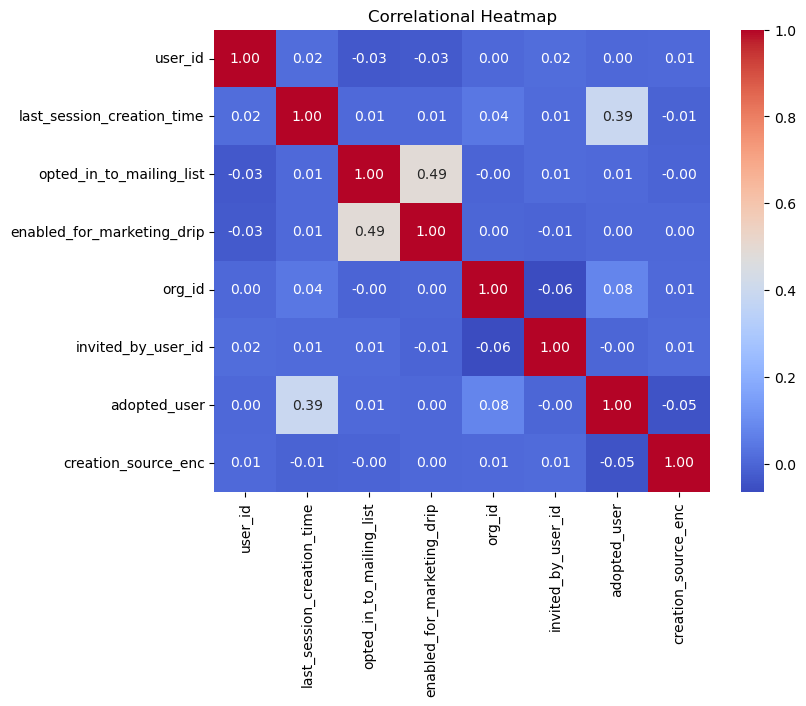

In [74]:
plt.figure(figsize = (8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlational Heatmap')
plt.show()

In [76]:
merged_df['adopted_user'] = merged_df['adopted_user'].astype(int)

In [77]:
merged_df.dtypes

user_id                         int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
adopted_user                    int32
creation_source_enc             int32
dtype: object

In [86]:
merged_df = merged_df.drop(columns = 'invited_by_user_id')

# Model Building to Determine Feature Importance

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [88]:
df = merged_df.select_dtypes(exclude=['object'])

In [108]:
df = df.drop(columns='user_id')

In [109]:
df.isnull().sum()

last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
adopted_user                  0
creation_source_enc           0
dtype: int64

In [110]:
X = df.drop(columns='adopted_user')
y = df['adopted_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)

In [111]:
lr_model = LogisticRegression()

lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC-AUC Score: {roc_auc:.2f}')

Accuracy: 0.81
F1 Score: 0.00
ROC-AUC Score: 0.13


In [112]:
print(y_train.value_counts())

adopted_user
0    5733
1    1325
Name: count, dtype: int64


In [113]:
xg_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

xg_model.fit(X_train, y_train)

y_pred = xg_model.predict(X_test)
y_pred_proba = xg_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC-AUC Score: {roc_auc:.2f}')

Accuracy: 0.88
F1 Score: 0.65
ROC-AUC Score: 0.86


C:\Users\josia\anaconda3\Desktop\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:34:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [114]:
rf_model = RandomForestClassifier()

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC-AUC Score: {roc_auc:.2f}')

Accuracy: 0.88
F1 Score: 0.65
ROC-AUC Score: 0.85


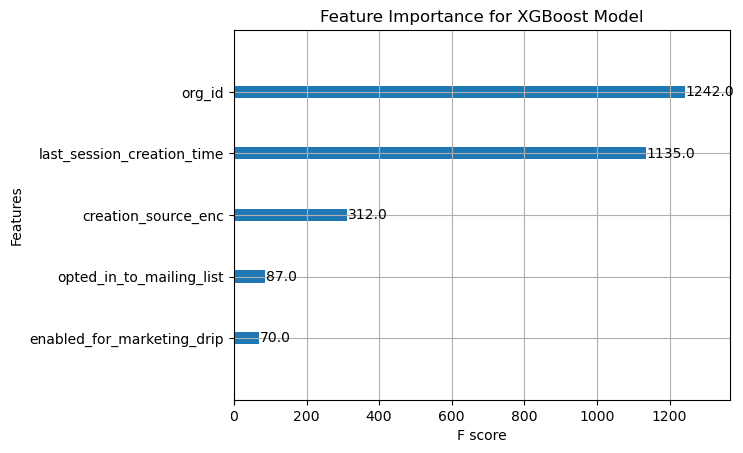

In [120]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xg_model)
plt.title('Feature Importance for XGBoost Model')
plt.show()


Feature Importances:
                      Feature  Importance
0  last_session_creation_time    0.721670
3                      org_id    0.228846
4         creation_source_enc    0.031204
1    opted_in_to_mailing_list    0.009781
2  enabled_for_marketing_drip    0.008500


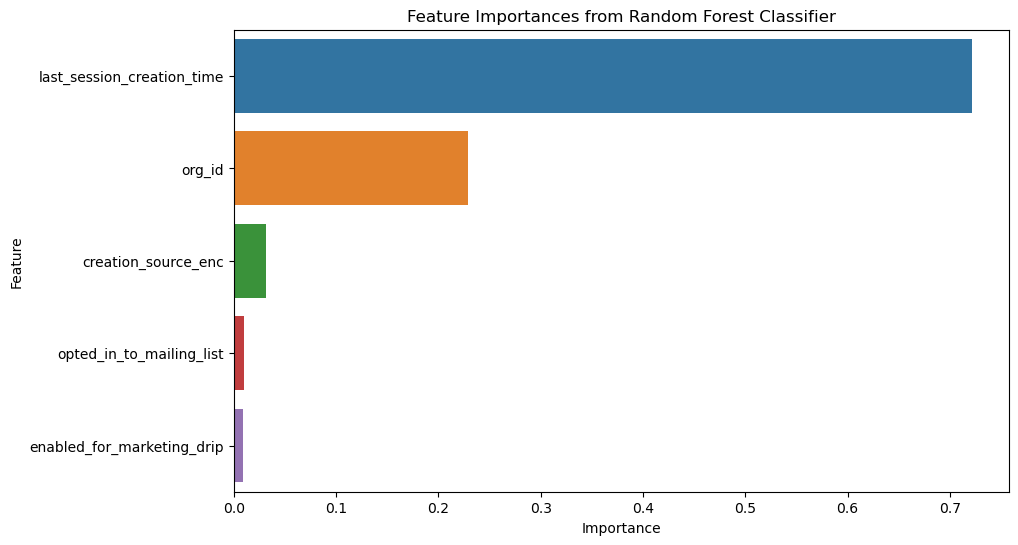

In [121]:
importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()